In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import operator
import pickle

In [2]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

from gensim.models import Nmf
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [4]:
from functions import log, plot_top_words

import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import plot_top_words

In [5]:
df = pd.read_csv('files/select_files.txt', delimiter= '\t')

df = df[df["abstract"] != 'xx']
df = df.dropna(subset=['abstract'])

#x.sub('.*doi', '', flags=re.IGNORECASE)


df["abstract"] = df["abstract"].apply( lambda x: re.sub('doi', '', x, flags=re.IGNORECASE) )
df["abstract"] = df["abstract"].apply( lambda x: re.sub(' .*10\.1371.* ', ' ', x) )

df["abstract"] = df["abstract"].apply( lambda x: word_tokenize(x)) 

df["abstract"] = df["abstract"].apply( lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x])) 

In [6]:
#count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
#doc_term_matrix = count_vect.fit_transform(df['abstract'].values.astype('U')) # U converts to unicode

In [7]:
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words="english")
tfidf = tfidf_vect.fit_transform(df['abstract'].values.astype('U'))

In [8]:
n_top_words = 10 # for bar graph
n_topics = 10

In [9]:
nmf1 = NMF(
    n_components=n_topics,
    beta_loss="frobenius", #"frobenius"
    solver="cd",
    max_iter=1000,
    l1_ratio=0.5,
).fit(tfidf)

log(f'fitting {n_topics}')

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


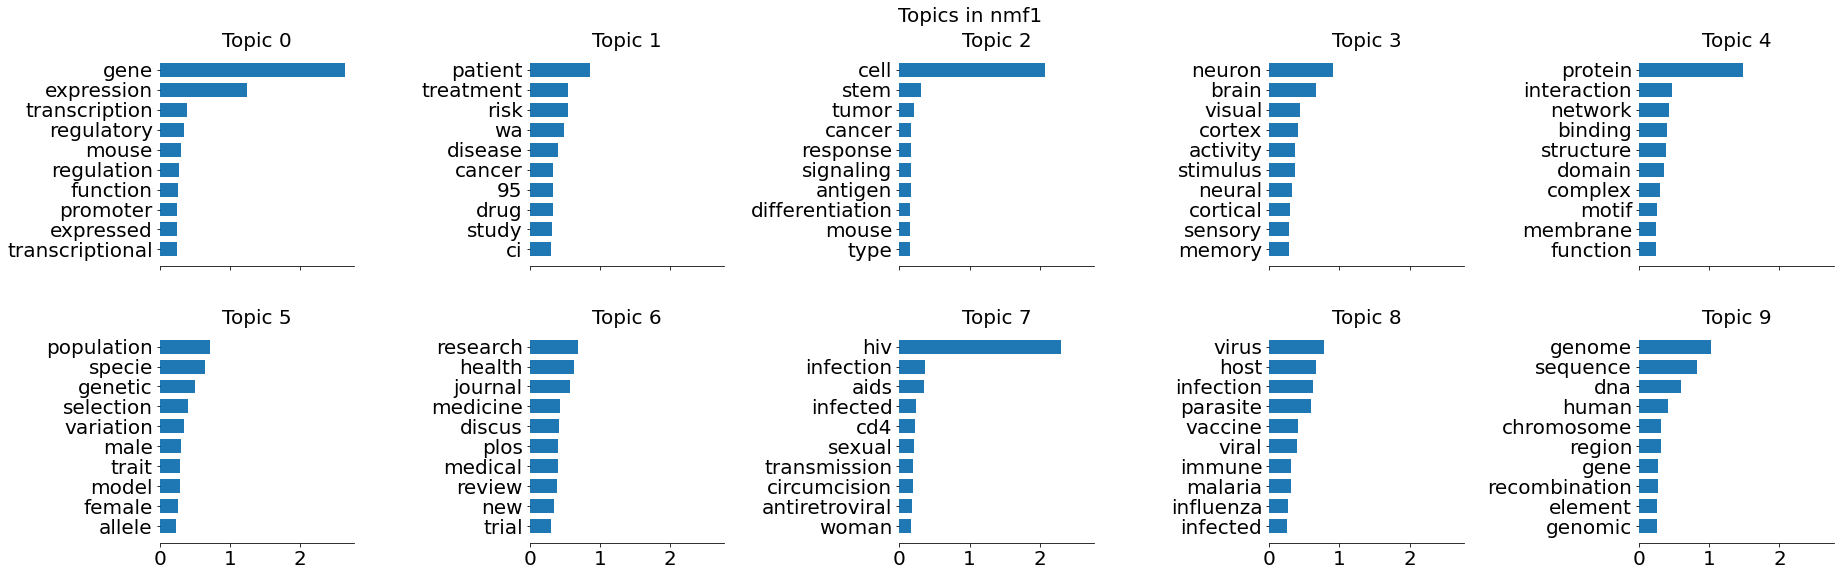

In [10]:
plot_top_words(
    nmf1, tfidf_vect.get_feature_names_out(), n_topics, n_top_words,"Topics in nmf1"
)

In [11]:
X_new = nmf1.transform(tfidf)
# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

In [12]:
df["topic"] = predicted_topics

In [13]:
topicDict = {}

for i,topic in enumerate(nmf1.components_):
    topicDict[i] = [tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-1:]][0]
    
print(topicDict)

{0: 'gene', 1: 'patient', 2: 'cell', 3: 'neuron', 4: 'protein', 5: 'population', 6: 'research', 7: 'hiv', 8: 'virus', 9: 'genome'}


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
with open(r'files/topicDict.pkl', 'wb') as f:
    pickle.dump(topicDict, f)
    
log(f'saving main word of topic to files/topicDict.pkl')

In [15]:
df.to_csv(r'files/topics.txt', sep='\t', index = False)
log(f'Ran select_files.ipynb succesfully')